## Table of Contents



1. Introduction


2. Loading Libraries


3. Data Loading


4. Handling Outliers


5. Checking number of unique values in each column.


6. Feature Engineering

    * Mean encoding of few relevant Features

    * Rolling Window Features


7. Train, Validation and Test


8. Modelling and Evaluation
    * Ridge Regression
    * Decision Tree
    * RandomForest Regressor
    * LightGBM Regressor


9. Conclusion

### Introduction

In this project, we are trying to forecast Sourcing costs based on the  ProductType, Manufacturer, Area_Code, Sourcing_Channel, Product_Size, Product_Type and Month_of_Sourcing as dependent variables.

This is DS/ML Challenge from MAERSK Group called "Sourcing Costs Forecast" where the task is to predict Sourcing cost for Jun-21 and Training set was from Jul-20 to May-21. We were suppose to iterate over Different ML models and come up closest possible to testing dataset using training dataset and feature engineering.

For this particular problem my approach was as follows:
    * Get Some EDA (Exploratory Data Analysis) on the data set EDA.ipynb will help in finding that.
    * Do some feature engineering after getting better understanding from EDA (Exploratory Data Analysis).
    * Train, Test and Validation split (Train- 10 months, Test- 1 month, Validation- 1 month).
    * Do some modelling over the Dataset.
    * Select one best model on the basis of RMSE score and R-squared Value.
    * Calculate Feature importance and check whether the engineered feature were important or not.

### Loading required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder,minmax_scale,PolynomialFeatures,StandardScaler,Normalizer
from sklearn.model_selection import KFold,GridSearchCV
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
%matplotlib inline
import datetime
from datetime import date, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import sys
import lightgbm as lgb
from lightgbm import LGBMRegressor

### Loading Dataset

In [2]:
train_df = pd.read_csv("train_data.csv")
train_df.columns = train_df.columns.str.replace(' ','_')

test_df = pd.read_csv("test_data.csv")
test_df.columns = test_df.columns.str.replace(' ','_')

In [3]:
train_df.describe()

,Sourcing_Cost
count,550176.000000
mean,108.817286
std,104.390093
min,-196.070000
25%,57.000000
50%,132.000000
75%,146.150000
max,32632.500000


In [4]:
test_df.describe()

,Sourcing_Cost
count,96.000000
mean,106.208021
std,52.359484
min,4.140000
25%,59.662500
50%,117.245000
75%,144.915000
max,234.710000


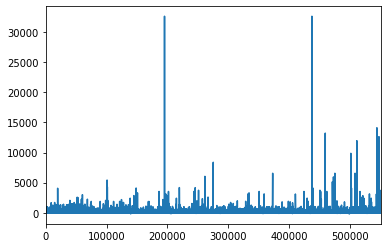

In [5]:
train_df['Sourcing_Cost'].plot.line()

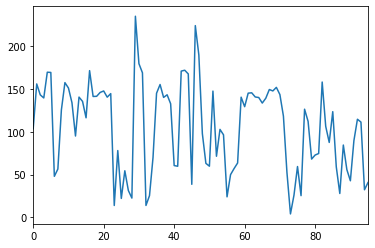

In [6]:
test_df['Sourcing_Cost'].plot.line()

### Handling outliers

In [7]:
mean = train_df['Sourcing_Cost'].mean()
std = train_df['Sourcing_Cost'].std()
train_df['Sourcing_Cost'] = np.where(train_df['Sourcing_Cost'] < 0, 
                                     abs(train_df['Sourcing_Cost']), train_df['Sourcing_Cost'])
train_df['Sourcing_Cost'] = np.where((train_df['Sourcing_Cost'] - mean).abs() > std, 
                                     mean, train_df['Sourcing_Cost'])

In the above cell i'm trying to get rid of the outliers. <br>
Now to get rid of outliers i applied two strategy:
* Strategy I - For all the negative entries, take there absolute values.
* Strategy II - For all the outliers viz. |val - mean| > std, i replaced them with mean values of the column.

#### After this step if we can check on some basic statistics then it'll be more or less same, in our training set and test set. 

`
Sourcing_Cost_Train
count	550176.000000
mean	109.229810
std	48.525341    
min	4.430000     {Minimum Value}
25%	66.480000    {25th Percentile}
50%	128.310000   {50th Percentile}
75%	144.660000   {75th Percentile}
max	212.980000   {Maximum Value}`  

`
Sourcing_Cost_Test
count	96.000000
mean	106.208021
std	52.359484
min	4.140000     {Minimum Value}
25%	59.662500    {25th Percentile}
50%	117.245000   {50th Percentile}
75%	144.915000   {75th Percentile}
max	234.710000   {Maximum Value}`

Plotting randomly 100 points to check how near my train set is to my test set. And it seems, that my random 100 points plot is quite close to my test set plot.

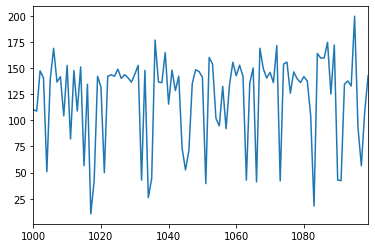

In [8]:
train_df['Sourcing_Cost'][1000:1100].plot.line()

### Checking Number of unique values in each column.

In [9]:
def uniqVals(df):
    for i in df.columns.drop('Sourcing_Cost'):
        print("{0} has {1} unique values.".format(i, df[i].nunique()))

In [10]:
uniqVals(train_df)

ProductType has 3 unique values.
Manufacturer has 3 unique values.
Area_Code has 45 unique values.
Sourcing_Channel has 4 unique values.
Product_Size has 3 unique values.
Product_Type has 2 unique values.
Month_of_Sourcing has 11 unique values.


In [11]:
uniqVals(test_df)

ProductType has 3 unique values.
Manufacturer has 3 unique values.
Area_Code has 45 unique values.
Sourcing_Channel has 4 unique values.
Product_Size has 3 unique values.
Product_Type has 2 unique values.
Month_of_Sourcing has 1 unique values.


## Feature Engineering

### Extracting month and year from Month of Sourcing for both Train and Test set

In [12]:
train_df['Month_of_Sourcing'] = pd.to_datetime(train_df['Month_of_Sourcing'], format = '%b-%y')
train_df['month'] = train_df['Month_of_Sourcing'].dt.month.astype(np.int32)
train_df['year'] = train_df['Month_of_Sourcing'].dt.year.astype(np.int32)

test_df['Month_of_Sourcing'] = pd.to_datetime(test_df['Month_of_Sourcing'], format = '%b-%y')
test_df['month'] = test_df['Month_of_Sourcing'].dt.month.astype(np.int32)
test_df['year'] = test_df['Month_of_Sourcing'].dt.year.astype(np.int32)

### Adding lag Features for lag shift upto 20 rows.
That means if one row refers to one date then i have created lag features for around 20 days.

In [13]:
lags = [1,2,5,20]
for lag in lags:
    train_df['Sourcing_Cost'+str(lag)] = train_df.groupby(['ProductType', 'Manufacturer', 'Area_Code', 
                                                                 'Sourcing_Channel', 'Product_Size', 'Product_Type'], 
                                                                as_index=False)['Sourcing_Cost'].shift(lag).astype(np.float16)

### Mean Encoding with one variable or more than one variables.
Encoding means converting our categorical variables to numerical features.
Mean Encoding is similar to other encoding techniques like OneHotEncoding, LabelEncoding and FrequencyEncoding. Where we are trying to get numerical features out of categorical features. This step is completely correlated to our EDA. The Features which we had analysed in our EDA has been implemented here. The feature that i thought of are:
    * ProductType
    * Manufacturer
    * Area Code
    * Sourcing Channel
    * Product Size
    * Product_Type
    * Area and Sourcing Channel
    * Area and Product Size
    * Area and Product Type
    * Area and Month
    * Area and Manufacturer
    * Area, Product Size and Month
    * Area, Product Type and Month
    * Area, Manufacturer and Month

In [14]:
train_df['product_type_avg'] = train_df.groupby('Product_Type')['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['manufacturer_cost_avg'] = train_df.groupby('Manufacturer')['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['area_cost_avg'] = train_df.groupby('Area_Code')['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['sourcing_channel_avg'] = train_df.groupby('Sourcing_Channel')['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['product_size_avg'] = train_df.groupby('Product_Size')['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['product_type_cost_avg'] = train_df.groupby(['Product_Type'])['Sourcing_Cost'].transform('mean').astype(np.float16)

train_df['area_channel_cost_avg'] = train_df.groupby(['Area_Code', 'Sourcing_Channel'])['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['area_prod_size_cost_avg'] = train_df.groupby(['Area_Code', 'Product_Size'])['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['area_prod_type_cost_avg'] = train_df.groupby(['Area_Code', 'Product_Type'])['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['area_month_cost_avg'] = train_df.groupby(['Area_Code', 'month'])['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['area_manufacturer_cost_avg'] = train_df.groupby(['Area_Code', 'Manufacturer'])['Sourcing_Cost'].transform('mean').astype(np.float16)

train_df['area_prod_size_month_cost_avg'] = train_df.groupby(['Area_Code', 'Product_Size', 'month'])['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['area_prod_type_month_cost_avg'] = train_df.groupby(['Area_Code', 'Product_Type', 'month'])['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['area_manufacturer_month_cost_avg'] = train_df.groupby(['Area_Code', 'Manufacturer', 'month'])['Sourcing_Cost'].transform('mean').astype(np.float16)

train_df['monthly_product_size_avg'] = train_df.groupby(['month', 'Product_Size'])['Sourcing_Cost'].transform('mean').astype(np.float16)

Rolling window average on the group by dataset over Sourcing Cost. I took window equal to 3 that means mid-weekly average over the train set. This is done to capture the trend over the period of last one year. 

In [15]:
train_df['rolling_cost_avg'] = train_df.groupby(['ProductType', 'Manufacturer', 'Area_Code', 'Sourcing_Channel', 'Product_Size', 
                                                  'Product_Type'])['Sourcing_Cost'].transform(lambda x: x.rolling(window=3).mean()).astype(np.float16)

I will be creating a Costing trend feature, which will be some positive value if the daily items sold are greater than the entire duration average <br>[Jul-20 to May-21] else negative.

In [16]:
train_df['monthly_avg'] = train_df.groupby(['ProductType', 'Manufacturer', 'Area_Code', 'Sourcing_Channel', 'Product_Size', 
                                                  'Product_Type', 'month'])['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['avg_cost'] = train_df.groupby(['ProductType', 'Manufacturer', 'Area_Code', 'Sourcing_Channel', 'Product_Size', 
                                                  'Product_Type'])['Sourcing_Cost'].transform('mean').astype(np.float16)
train_df['costing_trend'] = (train_df['monthly_avg'] - train_df['avg_cost']).astype(np.float16)
train_df.drop(['monthly_avg','avg_cost'],axis=1,inplace=True)

Adding all the trend features calculated over training period with test dataset. 

In [17]:
train_df.head()
test_df = test_df.merge(
    train_df.drop(["Sourcing_Cost", "Month_of_Sourcing", "month", "year"], axis = 1), 
    on = ['ProductType', 'Manufacturer', 'Area_Code', 'Sourcing_Channel', 'Product_Size', 'Product_Type'], 
    how = "inner").drop_duplicates()

### Converting my categorical values with one-hot encoding

In [18]:
dummy_vars = ['ProductType','Manufacturer','Area_Code','Sourcing_Channel','Product_Size','Product_Type']
for var in dummy_vars:
    dummies = pd.get_dummies(train_df[var], prefix = var, drop_first = False)
    train_df = pd.concat([train_df, dummies], axis = 1)

for var in dummy_vars:
    dummies = pd.get_dummies(test_df[var], prefix = var, drop_first = False)
    test_df = pd.concat([test_df, dummies], axis = 1)

Replacing NAN values with zeros, in both train and test set.

In [19]:
train_df.fillna(0, inplace = True)
test_df.fillna(0, inplace = True)

Creating a new function to remove unnecessary variables.

In [20]:
def remove_unnecessary_features(df, dummy_vars):
    X = df.loc[:, (df.columns != 'ProductType') & (df.columns != 'Manufacturer') & (df.columns != 'Product_Type') & 
               (df.columns != 'Area_Code') & (df.columns != 'Sourcing_Channel') & (df.columns != 'Product_Size') & 
               (df.columns != 'Month_of_Sourcing') & (df.columns != 'Sourcing_Cost')]
    Y = df['Sourcing_Cost']

    return X, Y

Train, Test and Validation Split <br>
Strategy:
    * Train (10 Months of Dataset)
    * Validation (May 21 considered as Validation Set)
    * Test (Jun 21 was given as Test Set)

In [21]:
val_df = train_df[(train_df['year'] == 2021) & (train_df['month'] == 5)]
train_df = train_df[(train_df['year'] != 2021) & (train_df['month'] != 5)]

In [22]:
train_x, train_y = remove_unnecessary_features(train_df, dummy_vars)
train_y_new = np.log(train_y)
val_x, val_y = remove_unnecessary_features(val_df, dummy_vars)
test_x, test_y = remove_unnecessary_features(test_df, dummy_vars)

Here i'm doing a little processing on train_y. I'm taking log() of train_y so that the value decreases and it will become easy to fit my models. Then after predicting i'll do the exp() of the output.

## Modelling and evaluation

### Ridge Regression

In [23]:
len(test_y)

522342

In [24]:
ridge = Ridge(alpha=0.1, normalize = True)
ridge.fit(train_x,train_y)

ridge_val_pred=ridge.predict(val_x)
print('R2 Score = ',r2_score(ridge_val_pred, val_y))
print('RMSE score = ',mean_squared_error(val_y, ridge_val_pred, squared=False), '/ 0.0')

ridge_pred=ridge.predict(test_x)
print('R2 Score = ',r2_score(ridge_pred, test_y))
print('RMSE score = ',mean_squared_error(test_y, ridge_pred, squared=False), '/ 0.0')

R2 Score =  0.8312743458307346
RMSE score =  17.832975847315172 / 0.0
R2 Score =  0.5866197566821021
RMSE score =  28.607781227466436 / 0.0


In the above cell, i'm using Ridge Regression for modelling. I tried Linear Regression as well. But it was not worth adding here because it gave very bad R-Squared score of 0.354
    * Validation Score- (R-Squared Value 0.831)
    * Test Score- (R-Squared Value 0.586)

### Decision Tree

In [25]:
decision_tree = DecisionTreeRegressor(max_depth = 8,
                                      min_samples_leaf = 5,
                                      max_leaf_nodes = 5)
decision_tree.fit(train_x,train_y_new)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=5,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [26]:
val_pred_y = decision_tree.predict(val_x)

print('R2 score = ',r2_score(val_y, np.exp(val_pred_y)), '/ 1.0')
print('MSE score = ',mean_squared_error(val_y, np.exp(val_pred_y)), '/ 0.0')
print('RMSE score = ',mean_squared_error(val_y, np.exp(val_pred_y), squared=False), '/ 0.0')

R2 score =  0.7958117397595044 / 1.0
MSE score =  473.7844614685595 / 0.0
RMSE score =  21.76659048791426 / 0.0


In [27]:
pred_y = decision_tree.predict(test_x)
# print(pred_y)
print('R2 score = ',r2_score(test_y, np.exp(pred_y)), '/ 1.0')
print('MSE score = ',mean_squared_error(test_y, np.exp(pred_y)), '/ 0.0')
print('RMSE score = ',mean_squared_error(test_y, np.exp(pred_y), squared=False), '/ 0.0')

R2 score =  0.7230774059087713 / 1.0
MSE score =  773.5452821767342 / 0.0
RMSE score =  27.81268203853656 / 0.0


Using a decision tree greatly improves the accurancy of model prediction. 
    * Validation Score- (R-Squared Value 0.795)
    * Test Score- (R-Squared Value 0.723)

### Random Forest Regressor (with cross-validation)

In [28]:
rf = RandomForestRegressor(n_estimators = 100,
              criterion = 'mse',
              max_depth = 10,
              min_samples_split = 5,
              min_samples_leaf = 3)
rf.fit(train_x, train_y_new)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
val_pred_y = rf.predict(val_x)

print('R2 score = ',r2_score(val_y, np.exp(val_pred_y)), '/ 1.0')
print('MSE score = ',mean_squared_error(val_y, np.exp(val_pred_y)), '/ 0.0')
print('RMSE score = ',mean_squared_error(val_y, np.exp(val_pred_y), squared=False), '/ 0.0')

R2 score =  0.9749100366235717 / 1.0
MSE score =  58.21703349921317 / 0.0
RMSE score =  7.630008748305153 / 0.0


In [30]:
pred_y = rf.predict(test_x)

print('R2 score = ',r2_score(test_y, np.exp(pred_y)), '/ 1.0')
print('MSE score = ',mean_squared_error(test_y, np.exp(pred_y)), '/ 0.0')
print('RMSE score = ',mean_squared_error(test_y, np.exp(pred_y), squared=False), '/ 0.0')

R2 score =  0.6398622809361785 / 1.0
MSE score =  1005.9953194860423 / 0.0
RMSE score =  31.717429269820123 / 0.0


Using RandomForestRegressor for training gave us bad results. 
With Validation and training score as:

    * Validation Score- (R-Squared Value 0.975)
    * Test Score- (R-Squared Value 0.6397)

### LightGBM Regressor

In [31]:
model = LGBMRegressor(n_estimators=330,
                    learning_rate=0.01,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    max_depth=8,
                    num_leaves=5,
                    min_child_weight=10)

model.fit(train_x, train_y_new, eval_set=[(train_x,train_y_new), (val_x,np.log(val_y))],
         eval_metric='rmse', verbose=20, early_stopping_rounds=30)

Training until validation scores don't improve for 30 rounds
[20]	training's rmse: 0.64538	training's l2: 0.416515	valid_1's rmse: 0.629099	valid_1's l2: 0.395765
[40]	training's rmse: 0.57125	training's l2: 0.326327	valid_1's rmse: 0.560572	valid_1's l2: 0.314241
[60]	training's rmse: 0.513727	training's l2: 0.263915	valid_1's rmse: 0.510947	valid_1's l2: 0.261067
[80]	training's rmse: 0.470531	training's l2: 0.2214	valid_1's rmse: 0.476048	valid_1's l2: 0.226622
[100]	training's rmse: 0.434667	training's l2: 0.188936	valid_1's rmse: 0.444769	valid_1's l2: 0.197819
[120]	training's rmse: 0.406121	training's l2: 0.164934	valid_1's rmse: 0.420665	valid_1's l2: 0.176959
[140]	training's rmse: 0.384121	training's l2: 0.147549	valid_1's rmse: 0.402384	valid_1's l2: 0.161913
[160]	training's rmse: 0.366386	training's l2: 0.134239	valid_1's rmse: 0.388118	valid_1's l2: 0.150636
[180]	training's rmse: 0.352226	training's l2: 0.124063	valid_1's rmse: 0.376048	valid_1's l2: 0.141412
[200]	train

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.01, max_depth=8,
              min_child_samples=20, min_child_weight=10, min_split_gain=0.0,
              n_estimators=330, n_jobs=-1, num_leaves=5, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [49]:
val_pred_y = model.predict(val_x)

print('R2 score = ',r2_score(val_y, np.exp(val_pred_y)), '/ 1.0')
print('MSE score = ',mean_squared_error(val_y, np.exp(val_pred_y)), '/ 0.0')
print('RMSE score = ',mean_squared_error(val_y, np.exp(val_pred_y), squared=False), '/ 0.0')

R2 score =  0.8681681278691948 / 1.0
MSE score =  305.8936516150314 / 0.0
RMSE score =  17.48981565411801 / 0.0


In [45]:
pred_y = model.predict(test_x)
test_df['pred'] = pred_y
test_df['pred_avg'] = test_df.groupby(['ProductType', 'Manufacturer', 'Area_Code', 'Sourcing_Channel', 'Product_Size', 
                                                  'Product_Type', 'month'])['pred'].transform('mean').astype(np.float16)

print('R2 score = ', r2_score(test_y, np.exp(test_df['pred_avg'])), '/ 1.0')
print('MSE score = ', mean_squared_error(test_y, np.exp(test_df['pred_avg'])), '/ 0.0')
print('RMSE score = ',mean_squared_error(test_y, np.exp(test_df['pred_avg']), squared=False), '/ 0.0')

R2 score =  0.7931417080639437 / 1.0
MSE score =  577.8302645596308 / 0.0
RMSE score =  24.03810026935637 / 0.0


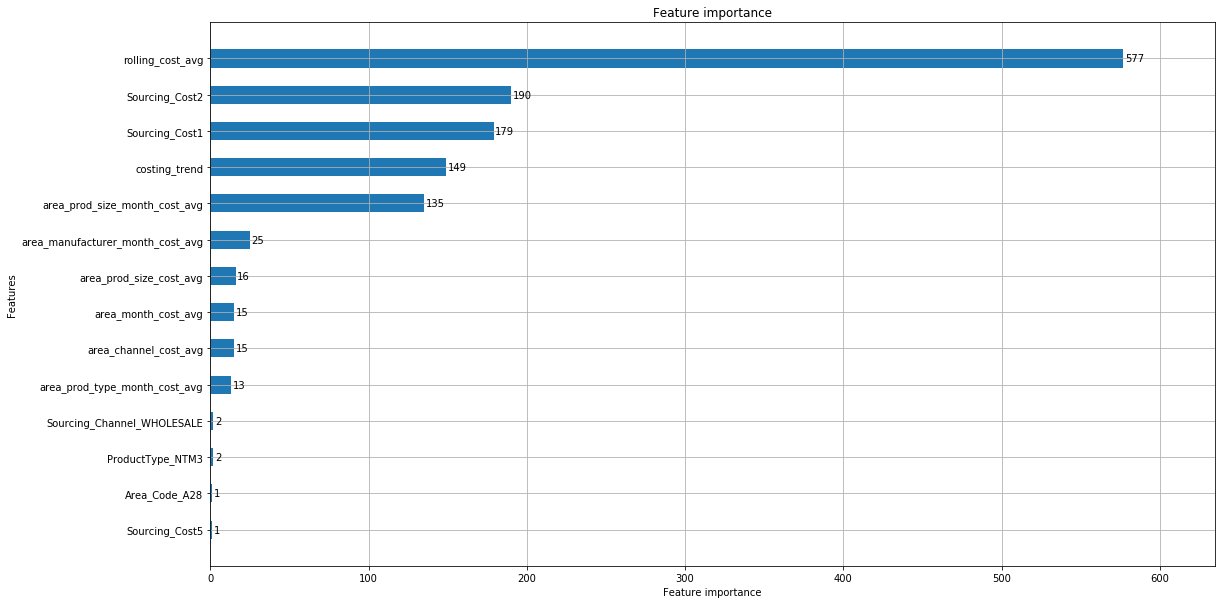

In [34]:
lgb.plot_importance(model, height=0.5, figsize=(18, 10))

Using LightGBM Regressor for training showing us that, this model is generalising very well on our dataset. <br>
With Validation and training score as:
    * Validation Score- (R-Squared Value 0.869)
    * Test Score- (R-Squared Value 0.7377)

### Conclusion

We are getting following results on applying data set on different models:

Model <br>
R-Squared Value

1. Ridge Regression <br>
   R-Squared Value: 0.586 <br>
   RMSE Score = 28.60


2. Decision Tree Regression <br>
   R-Squared Value: 0.723 <br>
   RMSE Score = 27.81
   
   
3. Random Forest Regression <br>
   R-Squared Value: 0.639 <br>
   RMSE Score = 31.71


4. LightGBM Regression <br>
   R-Squared Value: 0.737 <br>
   RMSE Score = 27.06

Feature Importance:
    * The Features that were created for Trend capture are the best found feature set. 
      For Eg: Lag Features, Rolling Window average Feature, Costing trend.
    * Other Features such as mean encoded features were also the good found.
    * Apart from above two only one-hot encoded features were used.